In [1]:
# import os
# import json
# import numpy as np
# import networkx as nx
# import matplotlib as mpl
# import scipy.stats as sst

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../scripts/')
import plottingUtils as plu

import json
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sst

In [2]:
#mpl.rc('text',usetex=False)
dpi=100
basefigdir = '/home/sidreed/thesis_SidReed/writing/nontext/figures'
pal = sns.color_palette("coolwarm")

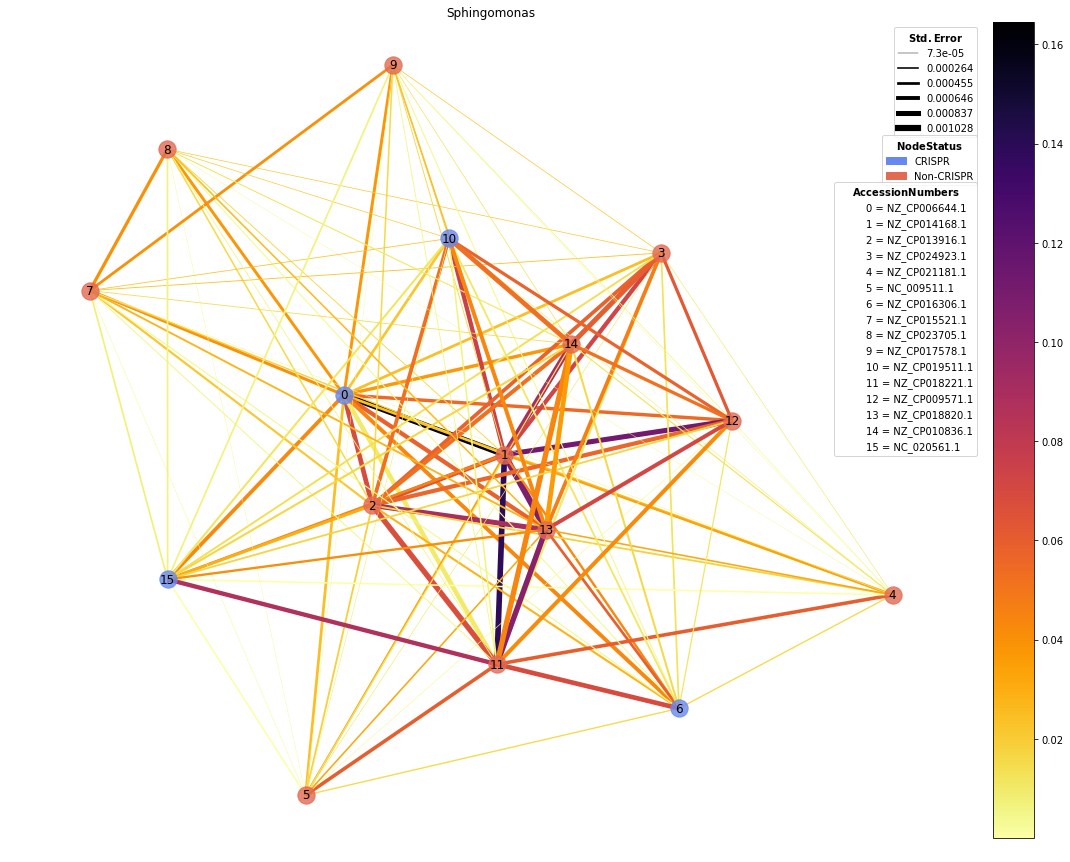

In [71]:
rnetpath = '/home/sidreed/thesis_SidReed/plotnets/Sphingomonas_plot_network.json'
df,net,name = plu.loadnetwork(rnetpath,returnname=True)
plu.plotNetwork(net,df,
              seed=19,
              dpi=dpi,
              name=name,
              ccol=pal[0],
              nccol=pal[-1],
              edge_cmap= plt.cm.inferno_r,
              save='{}/network.png'.format(basefigdir),
              layout=nx.spring_layout,
              width_scaling=6000)

In [7]:
andf = pd.DataFrame(json.load(open('../data/fasta_crispr_annotation_df.json')))
mmdf = plu.loadMarkoOnly(andf)
mmdf.shape

(115, 8)

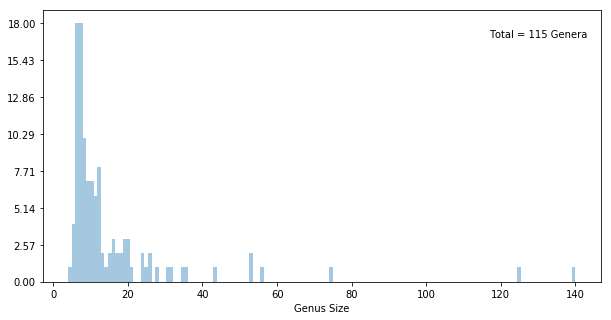

In [8]:
plu.genusSizeDist(mmdf,dpi=dpi,
    file='{}/genus_size_dist.png'.format(basefigdir))

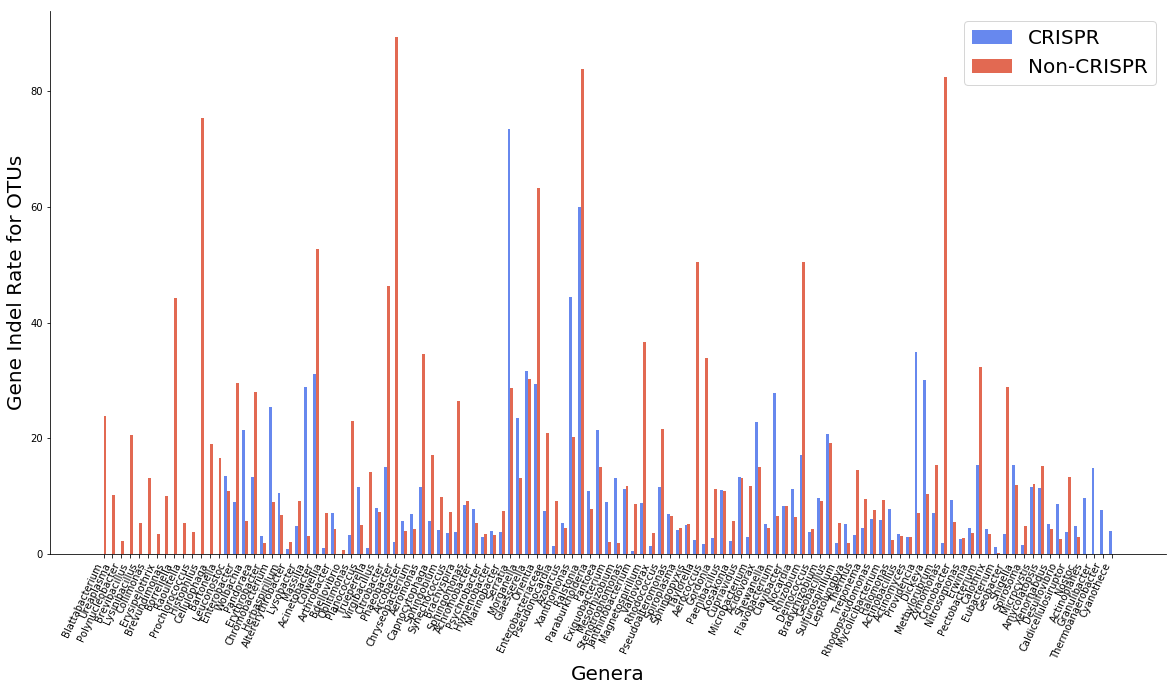

In [41]:
plu.multiBarPlot(mmdf,['c_indel','nc_indel']
            ,'Gene Indel Rate for OTUs',width=1,dpi=dpi,
        file='{}/c_nc_indel_bar.png'.format(basefigdir))

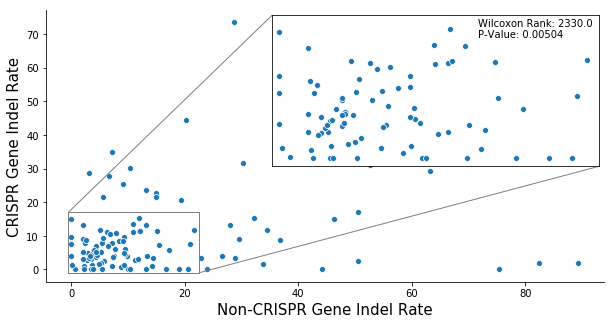

In [46]:
plu.cVsncRate(mmdf,dpi=dpi,
        file='{}/c_nc_rate_scatter.png'.format(basefigdir))

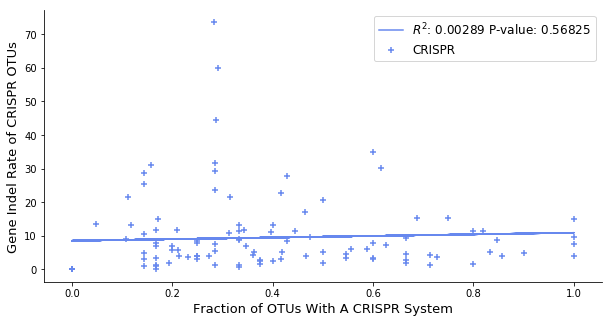

In [52]:
plu.cratevscfrac(mmdf,dpi=dpi,
    file='{}/crate_cfrac_scatter.png'.format(basefigdir))

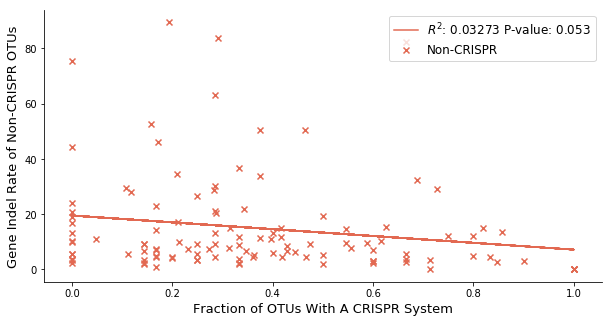

In [54]:
plu.ncratevscfrac(mmdf,dpi=dpi,
    file='{}/ncrate_cfrac_scatter.png'.format(basefigdir))

In [20]:
mdf,stats = plu.loadReports()
finaldf = plu.finaldf(mdf,stats).drop('Streptomyces')
nohdf = finaldf[(finaldf['c_indel'] != 100) & (finaldf['nc_indel'] != 100)]

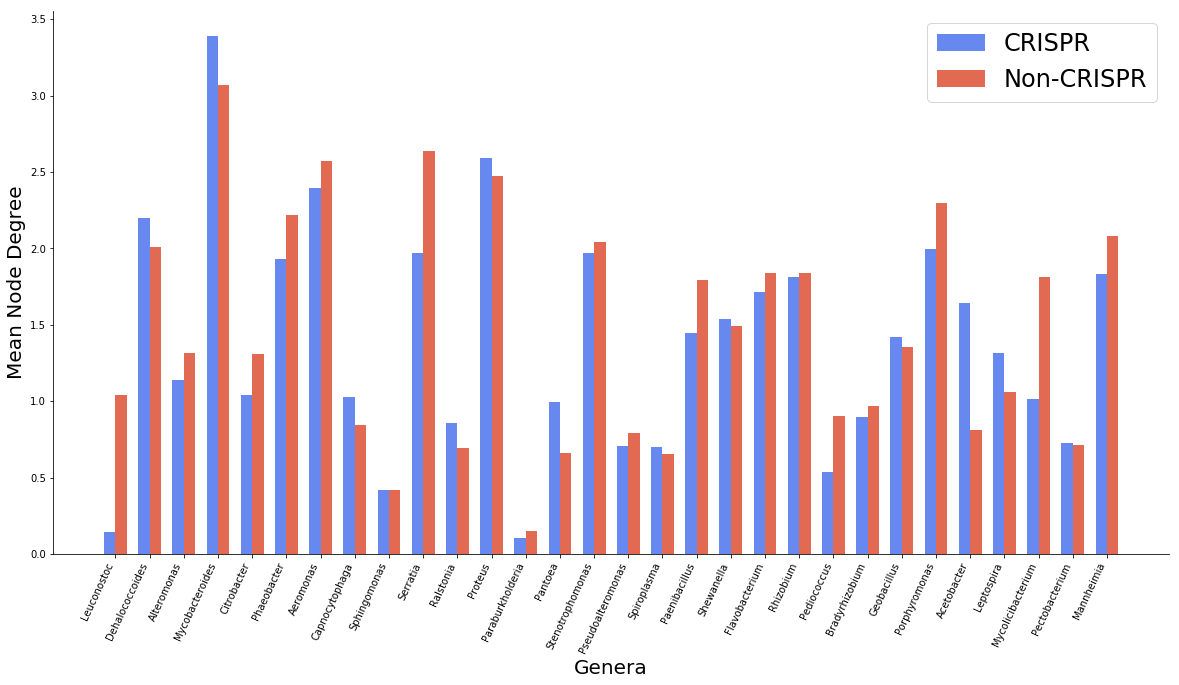

In [57]:
plu.multiBarPlot(nohdf,['c_mean_deg','nc_mean_deg'],
    'Mean Node Degree',width=1,dpi=dpi,lsize=24,
        file='{}/c_nc_deg_bar.png'.format(basefigdir))

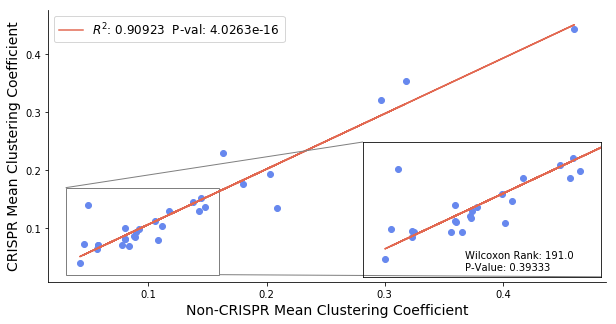

In [60]:
plu.cVsncClust(nohdf,dpi=dpi,
    file='{}/c_nc_clust_scatter.png'.format(basefigdir))

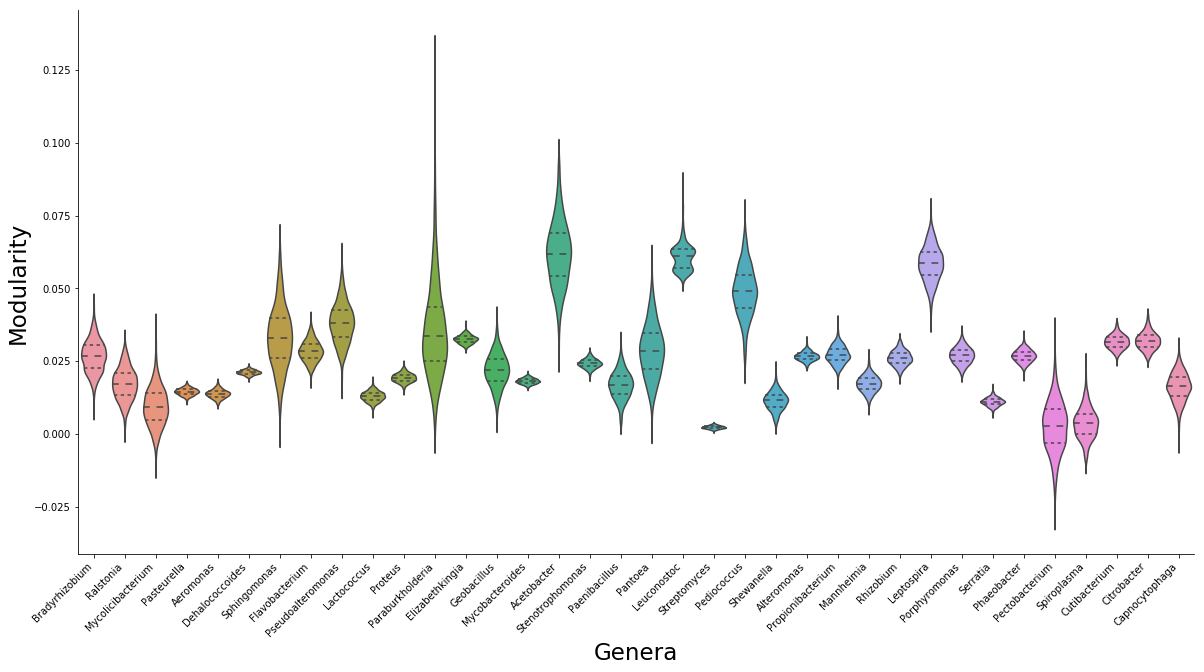

In [68]:
plu.violinPlot(stats,col='modularity',dpi=dpi,
                 file='{}/mod_violin.png'.format(basefigdir))

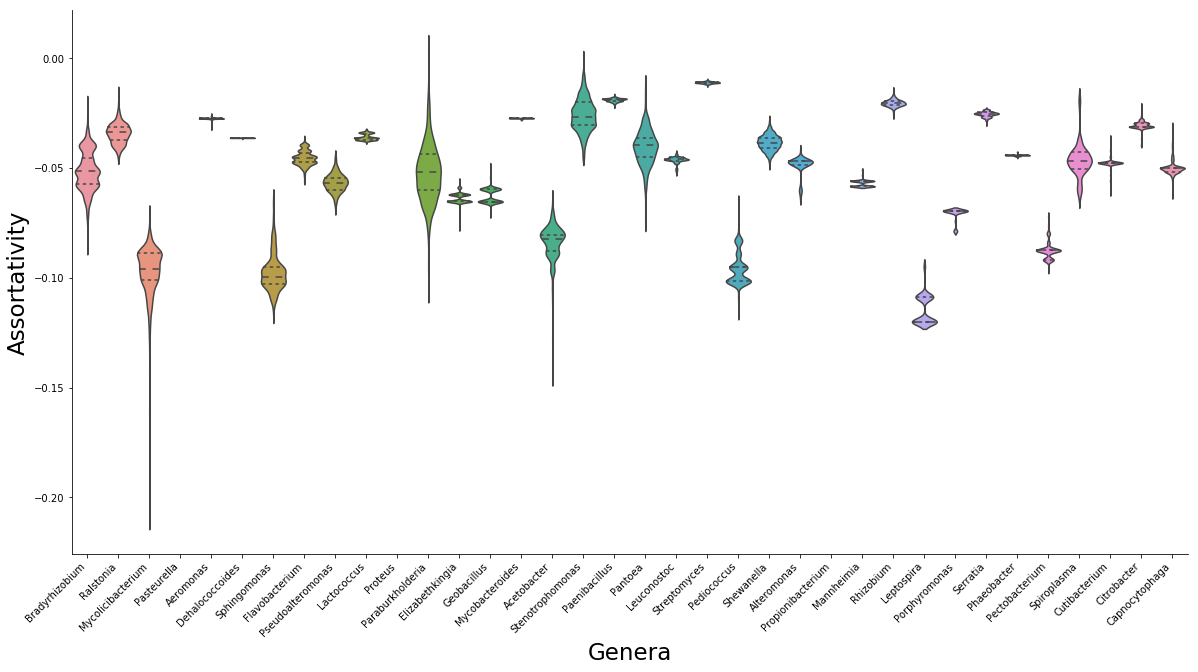

In [67]:
plu.violinPlot(stats,col='assortativity',dpi=dpi,
               file='{}/asst_violin.png'.format(basefigdir))

/home/sidreed/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


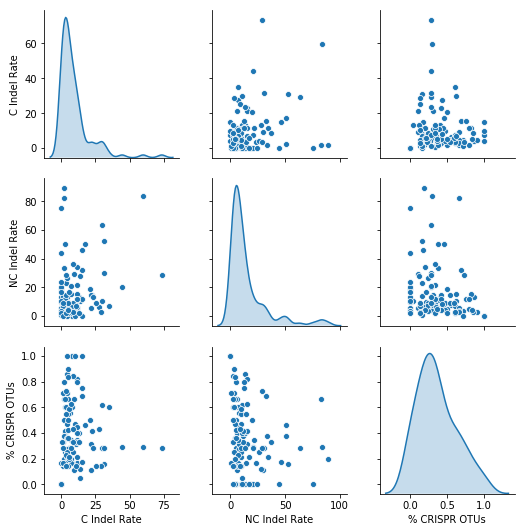

In [107]:
# nohdf.head()
# pairdf = nohdf.drop(['c_sem_indel','nc_sem_indel',
#                      't_otus','cnc_ratediff'],1)
# pairdf.columns = ['C Indel Rate','NC Indel Rate','Mean Modularity',
#                   'Mean Assortativity','C Mean Degree','NC Mean Degree',
#                   'C Mean Clustering','NC Mean Clustering',
#                   '% CRISPR OTUs '
#                  ]
pairdf = mmdf.drop(['c_sem_indel','nc_sem_indel',
                     'int_sem_indel','t_otus','int_indel'],1)
pairdf.columns = ['C Indel Rate',#'Internal Indel Rate',
                  'NC Indel Rate','% CRISPR OTUs']
pairdf['Genus'] = pairdf.index
g = sns.pairplot(pairdf,diag_kind='kde')
g.savefig('{}/pairplot.png'.format(basefigdir),
        dpi=dpi,format='png',frameon=False)

/home/sidreed/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


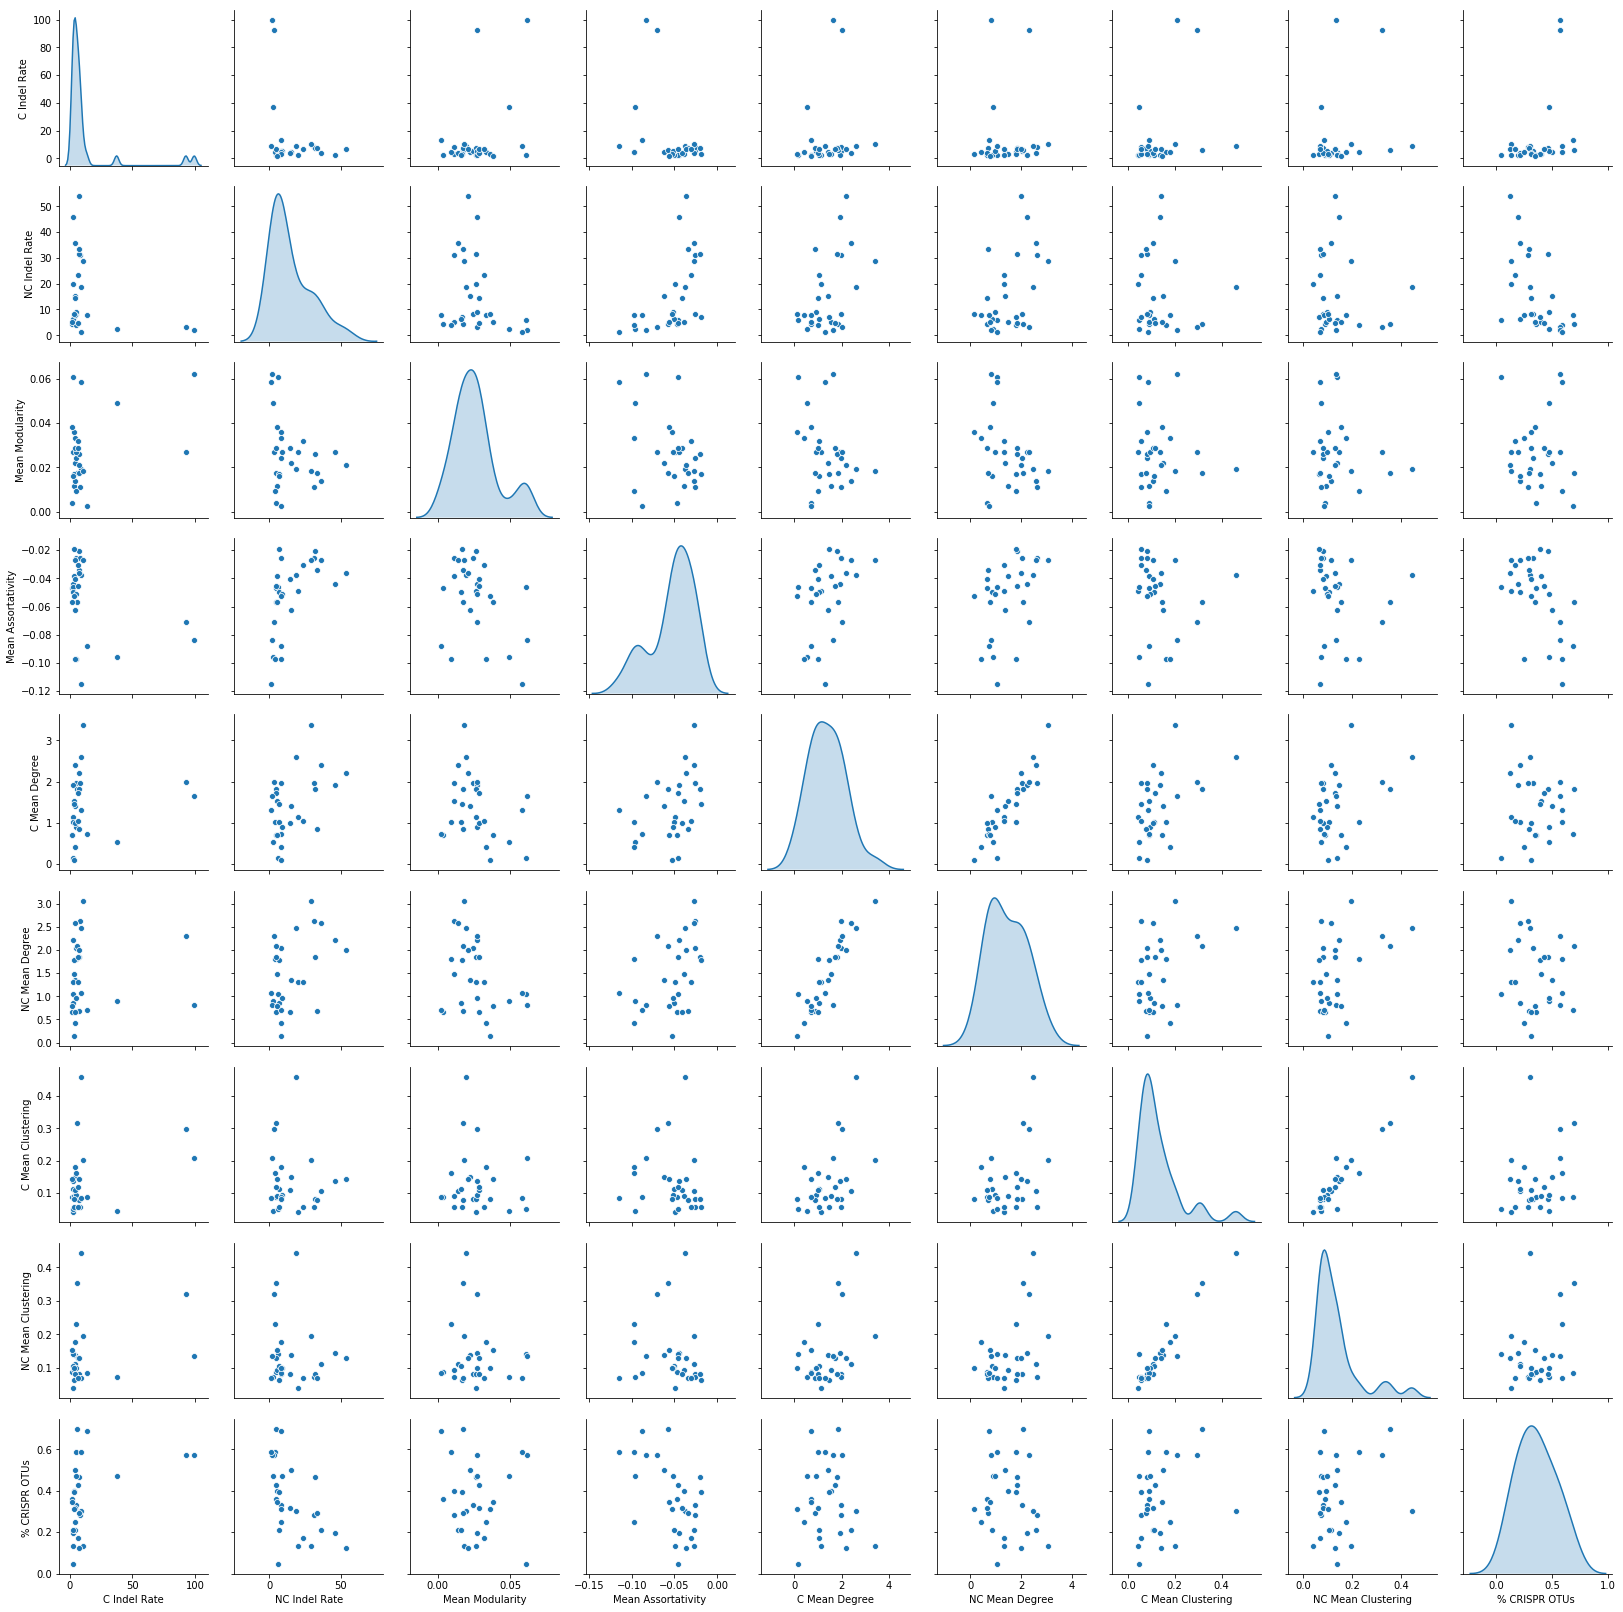

In [27]:
npairdf = nohdf.drop(['c_sem_indel','nc_sem_indel',
                     't_otus','cnc_ratediff'],1)
npairdf.columns = ['C Indel Rate','NC Indel Rate','Mean Modularity',
                  'Mean Assortativity','C Mean Degree','NC Mean Degree',
                  'C Mean Clustering','NC Mean Clustering',
                  '% CRISPR OTUs '
                 ]
npairdf['Genus'] = npairdf.index
g = sns.pairplot(npairdf,diag_kind='kde')
g.savefig('{}/network_pairplot.png'.format(basefigdir),
        dpi=dpi,format='png',frameon=False)

In [88]:
from statsmodels.stats.multitest import fdrcorrection
alpha = 0.05

In [88]:
corrdf = npairdf.reset_index().drop(['genus','Genus'],1)
cats = corrdf.columns
corrs,pvals = [],[]
for c in cats:
    for d in cats:
        tau = sst.kendalltau(corrdf[c],corrdf[d])
        corrs.append(tau.correlation)
        pvals.append(tau.pvalue)
cormat = np.asarray(corrs).reshape((len(cats),len(cats)))
qvals = fdrcorrection(pvals,alpha=alpha)
qvmat =  qvals[1].reshape((len(cats),len(cats)))
qrints = np.asarray([int(x) for x in qvals[0]])
qrmat = qrints.reshape((len(cats),len(cats)))

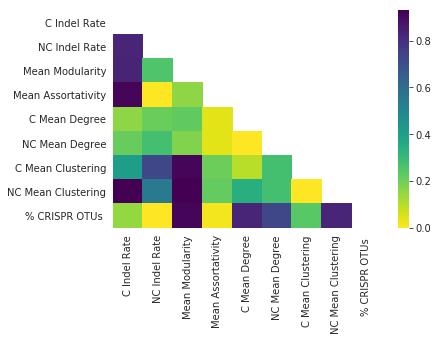

In [98]:
mask = np.zeros_like(qvmat)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    sns.heatmap(qvmat,cmap='viridis_r',
                xticklabels=cats,
                yticklabels=cats,
                mask=mask)

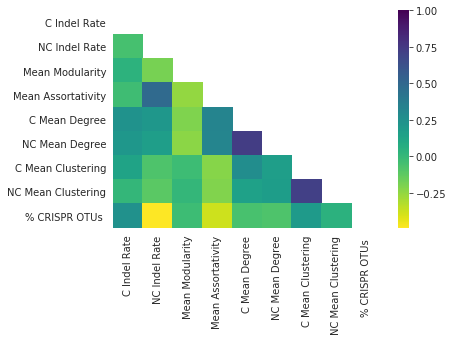

In [97]:
mask = np.zeros_like(cormat)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    sns.heatmap(cormat,cmap='viridis_r',
               xticklabels=cats,
               yticklabels=cats,
               mask=mask)

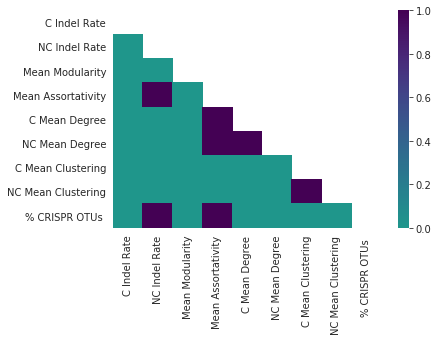

In [92]:
mask = np.zeros_like(qrmat)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    sns.heatmap(qrmat,cmap='viridis_r',
                center=alpha,
                xticklabels=cats,
                yticklabels=cats,
                mask=mask)